In [8]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import mlflow.sklearn 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  precision_recall_curve,classification_report,precision_score,recall_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [9]:
df=pd.read_csv("loan_approval.csv")
df

,name,city,income,credit_score,loan_amount,years_employed,points,loan_approved
0,Allison Hill,East Jill,113810,389,39698,27,50.0,False
1,Brandon Hall,New Jamesside,44592,729,15446,28,55.0,False
2,Rhonda Smith,Lake Roberto,33278,584,11189,13,45.0,False
3,Gabrielle Davis,West Melanieview,127196,344,48823,29,50.0,False
4,Valerie Gray,Mariastad,66048,496,47174,4,25.0,False
...,...,...,...,...,...,...,...,...
1995,James Schaefer,Robertton,92163,770,12251,13,85.0,True
1996,Diana Lin,New Frank,38799,635,48259,17,40.0,False
1997,Brandon Meyer,East Haley,41957,763,16752,5,60.0,True
1998,Jason Price,Adamland,139022,360,24031,35,55.0,False


In [10]:
print("---"*20)
print("EXPLORING DATA :")
print("Shape of data",df.shape)
print("---"*20)
print("dimension of data :",df.ndim)
print("---"*20)
print("Type of data:",df.dtypes)
print("---"*20)
print("total null values are :", df.isnull().sum())
print("---"*20)
print("Total duplicate values :",df.duplicated().sum())
print("---"*20)


------------------------------------------------------------
EXPLORING DATA :
Shape of data (2000, 8)
------------------------------------------------------------
dimension of data : 2
------------------------------------------------------------
Type of data: name               object
city               object
income              int64
credit_score        int64
loan_amount         int64
years_employed      int64
points            float64
loan_approved        bool
dtype: object
------------------------------------------------------------
total null values are : name              0
city              0
income            0
credit_score      0
loan_amount       0
years_employed    0
points            0
loan_approved     0
dtype: int64
------------------------------------------------------------
Total duplicate values : 0
------------------------------------------------------------


In [11]:
print("description of data",df.describe())

description of data               income  credit_score   loan_amount  years_employed       points
count    2000.000000   2000.000000   2000.000000     2000.000000  2000.000000
mean    90585.977000    573.946000  25308.503000       20.441000    56.680000
std     34487.874907    160.564945  14207.320147       11.777813    18.638033
min     30053.000000    300.000000   1022.000000        0.000000    10.000000
25%     61296.250000    433.000000  12748.750000       10.000000    45.000000
50%     90387.500000    576.000000  25661.500000       21.000000    55.000000
75%    120099.750000    715.000000  37380.500000       31.000000    70.000000
max    149964.000000    850.000000  49999.000000       40.000000   100.000000


In [12]:
df.columns

Index(['name', 'city', 'income', 'credit_score', 'loan_amount',
       'years_employed', 'points', 'loan_approved'],
      dtype='object')

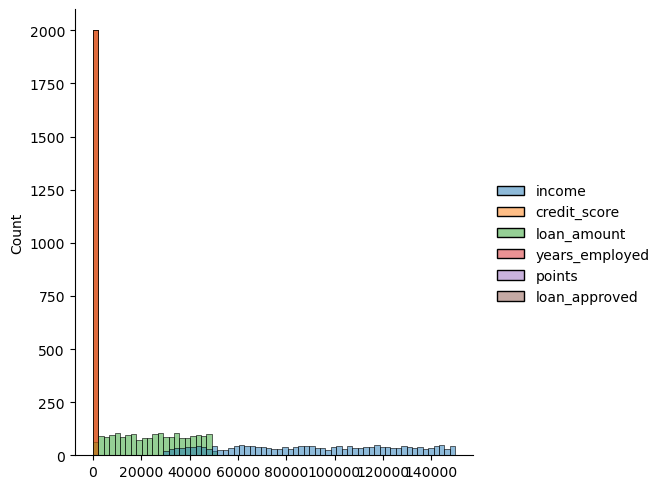

In [53]:
sns.displot(data=df)

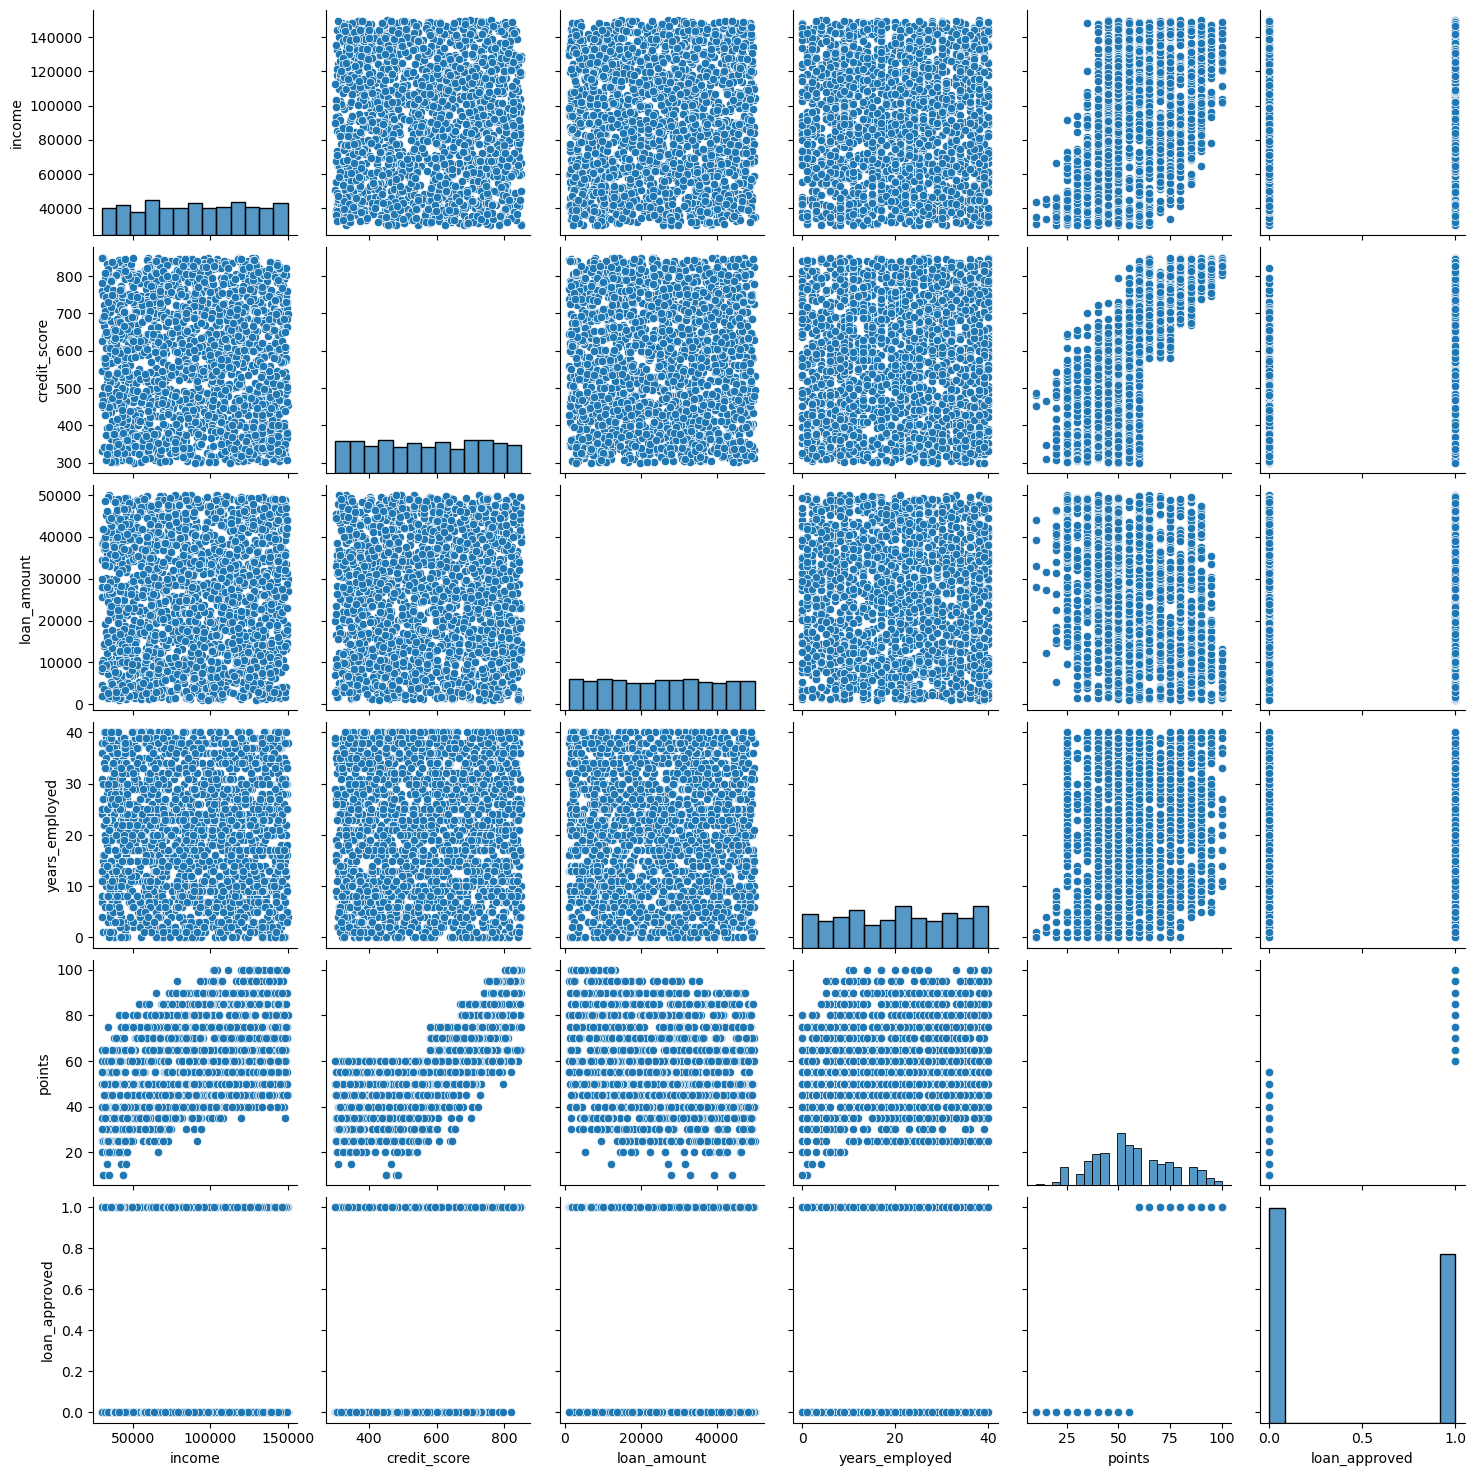

In [46]:
sns.pairplot(data=df)

In [ ]:
x=df.select_dtypes(include=['int64',"float64"])
y=df['loan_approved']
si=StandardScaler()
x=si.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split (x,y,random_state=42,test_size=0.20)


In [33]:
class ModelTrainer:
    def __init__(self) -> None:
        self.model = RandomForestClassifier(
            n_estimators=100,
            random_state=42
        )

    def train(self, x_train, y_train) -> None:
        self.model.fit(x_train, y_train)

    def predict(self, x_test):
        return self.model.predict(x_test)



In [50]:
def evaluate(y_true, y_pred) -> float:
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return accuracy_score(y_true, y_pred)


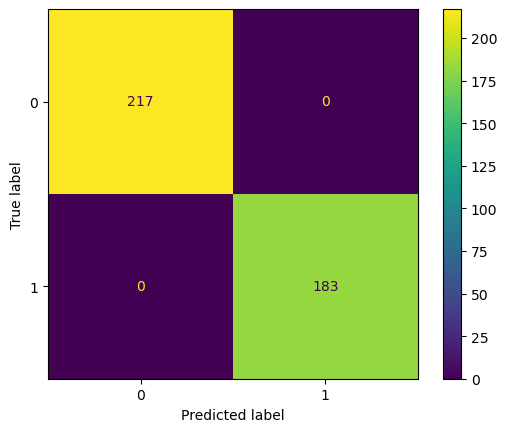

Model Accuracy: 1.0
Model and scaler saved successfully.


In [64]:
import os
import joblib

trainer = ModelTrainer()

with mlflow.start_run():
    trainer.train(x_train, y_train)

    predictions = trainer.predict(x_test)
    acc = evaluate(y_test, predictions)

    mlflow.log_param("n_estimators", 100)
    mlflow.log_metric("accuracy", acc)

    print(f"Model Accuracy: {acc}")

    os.makedirs("models", exist_ok=True)

    joblib.dump(trainer.model, "models/model.pkl")
    joblib.dump(si,"models/scaler.pkl")

print("Model and scaler saved successfully.")


In [57]:
!pip install fastapi uvicorn


In [65]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np


app = FastAPI(title="ML Project")


model = joblib.load("models/model.pkl")
scaler = joblib.load("models/scaler.pkl")


class InputFeature(BaseModel):
    city: int
    income: int
    credit_score: int
    loan_amount: int
    years_employed: int
    points: float


@app.get("/")
def home():
    return {"message": "API is running successfully 🚀"}

@app.post("/predict")
def predict(data: InputFeature):
    try:
        
        features = np.array([
            data.city,
            data.income,
            data.credit_score,
            data.loan_amount,
            data.years_employed,
            data.points
        ]).reshape(1, -1)

        scaled_features = scaler.transform(features)

        
        prediction = model.predict(scaled_features)

        return {"prediction": int(prediction[0])}

    except Exception as e:
        return {"error": str(e)}
